<h1>미션소개</h1>
<p>오토인코더를 활용하여 문서 이미지의 품질을 향상시키고, 문서의 내용을 최대한 복원하는 모델을 구현해 봅시다. 문서는 습기, 찢김, 얼룩 등 다양한 이유로 손상될 수 있는데요. 이번 미션의 목표는 손상된 문서에서 노이즈를 제거하여 원본 문서를 최대한 복원하는 것</p>

<h1>데이터 소개</h1>

- 데이터링크: https://www.kaggle.com/competitions/denoising-dirty-documents
- train: 손상된 문서(모델 훈련용)
- train_cleaned: 손상된 문서의 원본(모델 훈련용)
- test: 손상된 문서(모델 테스트용)

<h3>환경설정</h3>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageFilter
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.transforms import v2
import math
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pytorch_ssim



In [3]:
# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


<h3>데이터 준비</h3>

In [2]:
# 폴더 경로 설정
train_dir = "autodata/denoising-dirty-documents/train"
train_cleaned_dir = "autodata/denoising-dirty-documents/train_cleaned"
test_dir = "autodata/denoising-dirty-documents/test"

# 이미지 파일 읽기 함수
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if filename.endswith(".png"):  # PNG 파일만 가져오기
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)  # OpenCV로 이미지를 읽음 (BGR 형식)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환
            images.append(img)
    return images

# 이미지 불러오기
train_images = load_images_from_folder(train_dir)
train_cleaned_images = load_images_from_folder(train_cleaned_dir)
test_images = load_images_from_folder(test_dir)

# 결과 출력
print(f"Train: {len(train_images)}")
print(f"Train Cleaned: {len(train_cleaned_images)}")
print(f"Test: {len(test_images)}")

Train: 144
Train Cleaned: 144
Test: 72


<h3>1. 데이터 전처리<h3>

1-1 데이터 크기확인

In [4]:
# 각 데이터셋의 이미지 크기 추출
train_sizes = [img.shape[:2] for img in train_images]  # train 이미지의 크기 (height, width)
train_cleaned_sizes = [img.shape[:2] for img in train_cleaned_images]  # train_cleaned 이미지의 크기
test_sizes = [img.shape[:2] for img in test_images]  # test 이미지의 크기

# 유니크한 이미지 크기 계산
train_unique_sizes = np.unique(train_sizes, axis=0)  # train 이미지의 유니크 크기
train_cleaned_unique_sizes = np.unique(train_cleaned_sizes, axis=0)  # train_cleaned 유니크 크기
test_unique_sizes = np.unique(test_sizes, axis=0)  # test 유니크 크기

# 결과 출력
print("Unique sizes in train:\n", train_unique_sizes)
print("Unique sizes in train_cleaned:\n", train_cleaned_unique_sizes)
print("Unique sizes in test:\n", test_unique_sizes)

Unique sizes in train:
 [[258 540]
 [420 540]]
Unique sizes in train_cleaned:
 [[258 540]
 [420 540]]
Unique sizes in test:
 [[258 540]
 [420 540]]


-분석-
- 데이터셋의 이미지 크기를 분석한 결과, (258×540)과 (420×540)의 두 가지 해상도가 존재함을 확인하였다.
이는 오토인코더 모델의 입력 크기를 통일하기 위해 사전 전처리(리사이즈 또는 패딩)가 필요함을 의미한다.

1-2 패딩적용 클래스 선언

- 패딩 방식으로 진행하면 문서의 비율을 유지하면서 크기를 통일할 수 있습니다.
특히 문서 복원 과제에서는 글자 왜곡이 생기면 모델 성능이 떨어질 수 있기 때문

In [5]:


#  PadToSize 클래스 (커스텀 패딩)
class PadToSize:
    def __init__(self, target_size, fill=1):
        self.target_size = target_size  # (높이, 너비)
        self.fill = fill

    def __call__(self, img):
        if isinstance(img, torch.Tensor):
            _, height, width = img.shape
        else:
            width, height = img.size  # PIL일 경우 (W, H)

        target_height, target_width = self.target_size

        pad_top = (target_height - height) // 2
        pad_bottom = target_height - height - pad_top
        pad_left = (target_width - width) // 2
        pad_right = target_width - width - pad_left

        return TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)


1-3 RGB 3채널 -> 1채널로 축소 클래스 선언
- 다른컬러가 크게 필요없기때문에 단순하게 처리하면 좀더 효율적이기 때문

In [6]:
class Grayscale:
    def __call__(self, img):
        pil_img = TF.to_pil_image(img) if isinstance(img, torch.Tensor) else img
        grayscale_img = pil_img.convert("L")
        return TF.to_tensor(grayscale_img)


1-4 원본이미지, 손상된이미지 한쌍으로 묶어주는 클래스 선언
- 입력 이미지의 노이즈를 제거해 원본을 복원하는 모델이기때문에 한쌍으로 묶어주는 작업필요

In [7]:
#  PairedImageDataset 클래스 (train + cleaned 세트 로드)
class PairedImageDataset(Dataset):
    def __init__(self, train_dir, train_cleaned_dir, transform=None):
        self.train_files = sorted(
            [os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith('.png')]
        )
        self.cleaned_files = sorted(
            [os.path.join(train_cleaned_dir, f) for f in os.listdir(train_cleaned_dir) if f.endswith('.png')]
        )
        assert len(self.train_files) == len(self.cleaned_files), "train과 cleaned 데이터셋의 크기가 다릅니다."
        self.transform = transform

    def __len__(self):
        return len(self.train_files)

    def __getitem__(self, idx):
        train_img = Image.open(self.train_files[idx]).convert('RGB')
        cleaned_img = Image.open(self.cleaned_files[idx]).convert('RGB')

        if self.transform:
            train_img = self.transform(train_img)
            cleaned_img = self.transform(cleaned_img)

        return train_img, cleaned_img

1-5 이미지데이터셋 클래스 선언
- 테스트데이터용 이미지 불러오는 역할 클래스

In [8]:
class ImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = sorted(
            [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.png')]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')  # RGB로 열기

        if self.transform:
            image = self.transform(image)

        return image

1-6 transform 
- 위에 선언된 클래스로 데이터 변환

In [9]:
# 최신 v2 버전 변환 파이프라인
transform = v2.Compose([
    v2.ToImage(),                              # PIL → Tensor 자동 변환
    PadToSize((420, 540), fill=1),             # 흰색 패딩
    v2.ToDtype(torch.float32, scale=True),     # float32 변환 및 0~1 정규화
    Grayscale(),                               # 그레이스케일 변환
])

1-7 PairedImageDataset 클래스 실행
- PairedImageDataset클래스를 실행하여 원본이미지, 손상이미지 한쌍으로 묶고 transform 데이터 만들기

In [10]:
#   데이터셋 로드
train_dataset = PairedImageDataset(
    train_dir="autodata/denoising-dirty-documents/train",
    train_cleaned_dir="autodata/denoising-dirty-documents/train_cleaned",
    transform=transform
)

#  DataLoader 추가
from torch.utils.data import DataLoader

# train / test 폴더 경로 설정
test_dir = "autodata/denoising-dirty-documents/test"

# 테스트 데이터셋 로드
test_dataset = ImageDataset(test_dir, transform=transform)

# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 로더 확인용 출력
print(" DataLoader 생성 완료!")
print(f"train 데이터 개수: {len(train_dataset)}")
print(f"test 데이터 개수: {len(test_dataset)}")

# 배치 크기 확인
train_batch, cleaned_batch = next(iter(train_loader))
print(f"train 배치 크기: {train_batch.shape}")
print(f"cleaned 배치 크기: {cleaned_batch.shape}")



 DataLoader 생성 완료!
train 데이터 개수: 144
test 데이터 개수: 72
train 배치 크기: torch.Size([16, 1, 420, 540])
cleaned 배치 크기: torch.Size([16, 1, 420, 540])


1-8 데이터 시각화 확인용


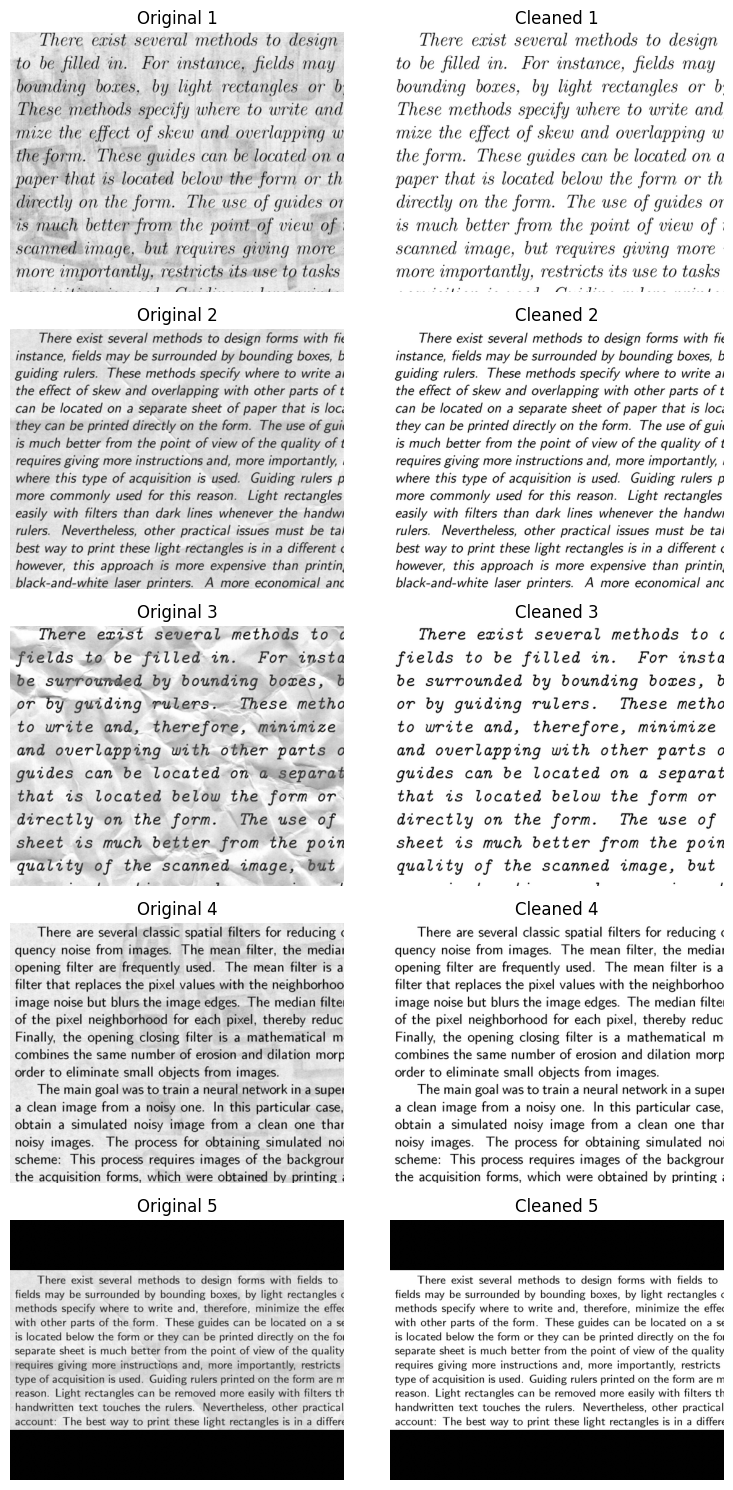

In [11]:


def visualize_paired_dataset(paired_loader, num_images=5):
    """
    PairedImageDataset 배치에서 원본(train)과 정제(cleaned) 이미지를 비교 시각화
    """
    # 한 배치만 가져오기
    for train_images, cleaned_images in paired_loader:
        fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 3))  # 2열, num_images 행
        for i in range(num_images):
            # 원본 이미지 (좌측)
            axes[i, 0].imshow(train_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[i, 0].set_title(f"Original {i+1}")
            axes[i, 0].axis('off')

            # 정제 이미지 (우측)
            axes[i, 1].imshow(cleaned_images[i].permute(1, 2, 0).cpu().numpy(), cmap='gray')
            axes[i, 1].set_title(f"Cleaned {i+1}")
            axes[i, 1].axis('off')

        plt.tight_layout()
        plt.show()
        break  # 첫 번째 배치만 시각화


visualize_paired_dataset(train_loader, num_images=5)


분석
- 학습데이터와 클린데이터 이미지가 잘매칭되어있는지 확인
- 패딩, 그레이스케일 변환등 전처리 결과 확인 결과 이상없습니다.

<h3>2. 모델링</h3> 

2-1 모델 선언
- 검색해서 찾은 4개의 모델을 정의한뒤에 성능평가해서 현재나의 프로젝트에 맞는 모델을 선택할 예정

In [ ]:
# ===============================================
# Autoencoder
# ===============================================
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# ===============================================
#  UNetAutoencoder
# ===============================================
class UNetAutoencoder(nn.Module):
    def __init__(self):
        super(UNetAutoencoder, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )

        # Decoder
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder
        d2 = self.up2(b)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        out = self.final(d1)
        return out


# ===============================================
#  DnCNN
# ===============================================
class DnCNN(nn.Module):
    def __init__(self, channels=1, num_layers=17):
        super(DnCNN, self).__init__()
        layers = [nn.Conv2d(channels, 64, 3, 1, 1), nn.ReLU(inplace=True)]
        for _ in range(num_layers-2):
            layers += [nn.Conv2d(64, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True)]
        layers += [nn.Conv2d(64, channels, 3, 1, 1)]
        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out  # Residual learning


# ===============================================
# Residual UNet
# ===============================================
class SRCNN(nn.Module):
    def __init__(self, num_channels=1):
        super(SRCNN, self).__init__()
        # Feature extraction
        self.layer1 = nn.Conv2d(num_channels, 64, kernel_size=9, padding=4)
        # Non-linear mapping
        self.layer2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        # Reconstruction
        self.layer3 = nn.Conv2d(32, num_channels, kernel_size=5, padding=2)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.layer3(x)
        return x


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models_dict = {
    'Autoencoder': Autoencoder().to(device),
    'UNetAutoencoder': UNetAutoencoder().to(device),
    'DnCNN': DnCNN().to(device),
    'SRCNN': SRCNN().to(device)
}

2-2 모델성능평가


In [ ]:
from sklearn.metrics import mean_squared_error
import time

# ================================
#  PSNR 계산 함수
# ================================
def calculate_psnr(true_image_np, reconstructed_image_np, data_range=1.0):
    mse = np.mean((true_image_np - reconstructed_image_np) ** 2)
    if mse == 0:
        return float('inf')
    return 10. * math.log10((data_range ** 2) / mse)

# ================================
#  모델 성능 평가 함수
# ================================
def evaluate_models(models, dataloader, device):
    results = []

    for model_name, model in models.items():
        model.eval()
        total_rmse = 0
        total_psnr = 0
        total_time = 0
        count = 0

        with torch.no_grad():
            for inputs in dataloader:
                inputs = inputs.to(device)

                # 🔹 시간 측정 시작
                start_time = time.time()
                outputs = model(inputs)
                end_time = time.time()

                # 🔹 시간 누적
                total_time += (end_time - start_time)

                # 🔹 RMSE 계산
                inputs_np = inputs.cpu().numpy().flatten()
                outputs_np = outputs.cpu().numpy().flatten()
                rmse = np.sqrt(mean_squared_error(inputs_np, outputs_np))
                total_rmse += rmse

                # 🔹 PSNR 계산
                psnr_value = calculate_psnr(inputs.cpu().numpy(), outputs.cpu().numpy())
                total_psnr += psnr_value

                count += 1

        avg_rmse = total_rmse / count
        avg_psnr = total_psnr / count
        avg_time = total_time / count

        results.append({
            'Model': model_name,
            'RMSE': avg_rmse,
            'PSNR': avg_psnr,
            'Inference_Time(s)': avg_time
        })

    return results

# ================================
#  모델 인스턴스 생성
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
models = {
    'Autoencoder': Autoencoder().to(device),
    'UNetAutoencoder': UNetAutoencoder().to(device),
    'DnCNN': DnCNN().to(device),
    'SRCNN': SRCNN().to(device)
}

# ================================
#  평가 실행
# ================================
results = evaluate_models(models, test_loader, device)



In [ ]:
import pandas as pd
# ================================
#  결과 정리 및 출력
# ================================
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="RMSE")
print(df_results)

             Model      RMSE       PSNR  Inference_Time(s)
2            DnCNN  0.007252  42.790481          20.737452
0      Autoencoder  0.365755   8.742716           0.162236
1  UNetAutoencoder  0.762073   2.388797          15.876388
3            SRCNN  0.793180   2.041328           2.185498


| 모델 | RMSE ↓ | PSNR ↑ | Inference Time (s) ↓ | 해석 |
|------|---------|---------|----------------------|------|
| **DnCNN** | **0.00725** | **42.79 dB** | 20.7 |  가장 좋은 복원 품질 (오차 매우 낮고, 이미지 품질 최고 수준). 단, 추론 속도는 약간 느림. |
| **Autoencoder** | 0.3657 | 8.74 dB | **0.16** | 기본 AE는 빠르지만, 오차가 큼 — 이미지가 매우 흐릿할 가능성 높음. |
| **UNetAutoencoder** | 0.7621 | 2.39 dB | 15.9 | 구조는 복잡하지만 학습이 제대로 안 되었거나 데이터 스케일 문제 가능성 큼. |
| **SRCNN** | 0.7932 | 2.04 dB | 2.18 | 저해상도 → 고해상도 변환에 강하지만, 지금 태스크(노이즈 제거/복원)엔 부적합해 보임. |


분석
- RMSE는 낮을수록좋고, PSNR은 높을 수록 좋은 상황

- DnCNN이 가장 뛰어난 결과가 나옴 (PSNR 42.8dB, RMSE 0.0072). 즉, 노이즈 제거,복원 목적에서는 DnCNN이 압도적으로 우세.

- 속도는 Autoencoder가 가장 빠르지만, 성능이 낮음.

- UNetAutoencoder / SRCNN은 구조는 복잡하지만 준수한편

- DnCNN으로 학습 진행하면 좋은 결과가 나올듯

- 하지만 현재 프로젝트는 로컬에서 진행중이기때문에 컴퓨터 성능이슈로 DnCNN은 다른 모델결과가 안좋으면 선택할 예정

- U-Net 구조 장점 인코더에서 특징을 추출하고, 디코더에서 복원하면서 스킵 연결(skip connection)을 통해 공간 정보를 보존합니다. 그래서 단순한 CNN Autoencoder보다 디테일한 문서 구조나 글자 선까지 복원하기 매우좋음

- 우선 UNetAutoencoder로 진행할 예정 해석에의해 이모델이 잘나올확률이 높아보입니다. 이게 안되면 -> SRCNN -> Autoencoder -> DnCNN으로 할예정 

2-3 모델 학습 구성

In [ ]:
# ----------------------------
#  모델 선언 (DnCNN)
# ----------------------------
model = UNetAutoencoder().to(device)

-   모델이 학습할 때 손실을 계산하고, 그걸 줄이기 위해 가중치를 업데이트하기위해 Loss + Optimizer 설정

In [ ]:
# ----------------------------
#  Loss + Optimizer
# ----------------------------
criterion_mse = nn.MSELoss()


def combined_loss(output, target, alpha=0.8):
    mse_loss = criterion_mse(output, target)
    ssim_loss = 1 - pytorch_ssim.ssim(output, target)
    return alpha * mse_loss + (1 - alpha) * ssim_loss  # 0.8:0.2 비율 추천

# ✅ 유넷 모델에 맞게 optimizer 선언
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

- 처음본 예제에서 결과가안좋아 샤프필터를 사용하면 이미지복원에 좀더 도움된다는 글을보아서 샤프필터 추가

In [ ]:
# ----------------------------
#  Sharpen Filter
# ----------------------------
def sharpen_image(tensor_img):
    img = tensor_img.squeeze().detach().cpu().numpy()
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel)
    sharpened = np.clip(sharpened, 0, 1)  # 값 범위 조정
    return torch.tensor(sharpened).unsqueeze(0)

- Sharpen Filter 추가, 기존에 결과물이 좋지않아 샤프필터 추가하였습니다.

2-3 모델 학습

In [ ]:
# ----------------------------
# 8️⃣ Training Loop (유넷)
# ----------------------------
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for train_imgs, cleaned_imgs in train_loader:
        train_imgs = train_imgs.to(device)
        cleaned_imgs = cleaned_imgs.to(device)

        optimizer.zero_grad()
        outputs = model(train_imgs)
        loss = combined_loss(outputs, cleaned_imgs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * train_imgs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {epoch_loss:.6f}")

#  학습 완료 후 저장
torch.save(model.state_dict(), "unet_autoencoder_final.pth")
print(" Training complete. Model saved as unet_autoencoder_final.pth")




Epoch [1/20] | Train Loss: 0.367467
Epoch [2/20] | Train Loss: 0.127861
Epoch [3/20] | Train Loss: 0.092770
Epoch [4/20] | Train Loss: 0.067177
Epoch [5/20] | Train Loss: 0.052589
Epoch [6/20] | Train Loss: 0.045381
Epoch [7/20] | Train Loss: 0.037740
Epoch [8/20] | Train Loss: 0.028418
Epoch [9/20] | Train Loss: 0.022552
Epoch [10/20] | Train Loss: 0.017569
Epoch [11/20] | Train Loss: 0.018905
Epoch [12/20] | Train Loss: 0.013733
Epoch [13/20] | Train Loss: 0.009767
Epoch [14/20] | Train Loss: 0.008201
Epoch [15/20] | Train Loss: 0.007129
Epoch [16/20] | Train Loss: 0.006400
Epoch [17/20] | Train Loss: 0.005667
Epoch [18/20] | Train Loss: 0.005772
Epoch [19/20] | Train Loss: 0.005362
Epoch [20/20] | Train Loss: 0.005020
✅ Training complete. Model saved as unet_autoencoder_final.pth


분석

- 손실율이 0.005점이면 엄청 좋은편, Unet인코더모델사용한건 좋은 선택이었습니다.
- 시각화해서 본다면 눈으로 원본이미지와 복원이미지가 거의 비슷하게 보일 가능성높음, 기존 코드에선 0.04대였지만 지금 로쓰율은 큰성과
- 에폭을 크게 늘려도보았지만 시간이 너무 오래걸려 현재 이방법이 최고인듯...현재 이모델도 로컬에서 192분소요되었기때문에 결과보고 좀더 가벼운모델로 해야될수도있음
- 하지만 샤프필터 추가와 Unetencoder사용이 테스트시 좋은결과로 이뤄질확률높음



2-4 훈련데이터 복원 시각화

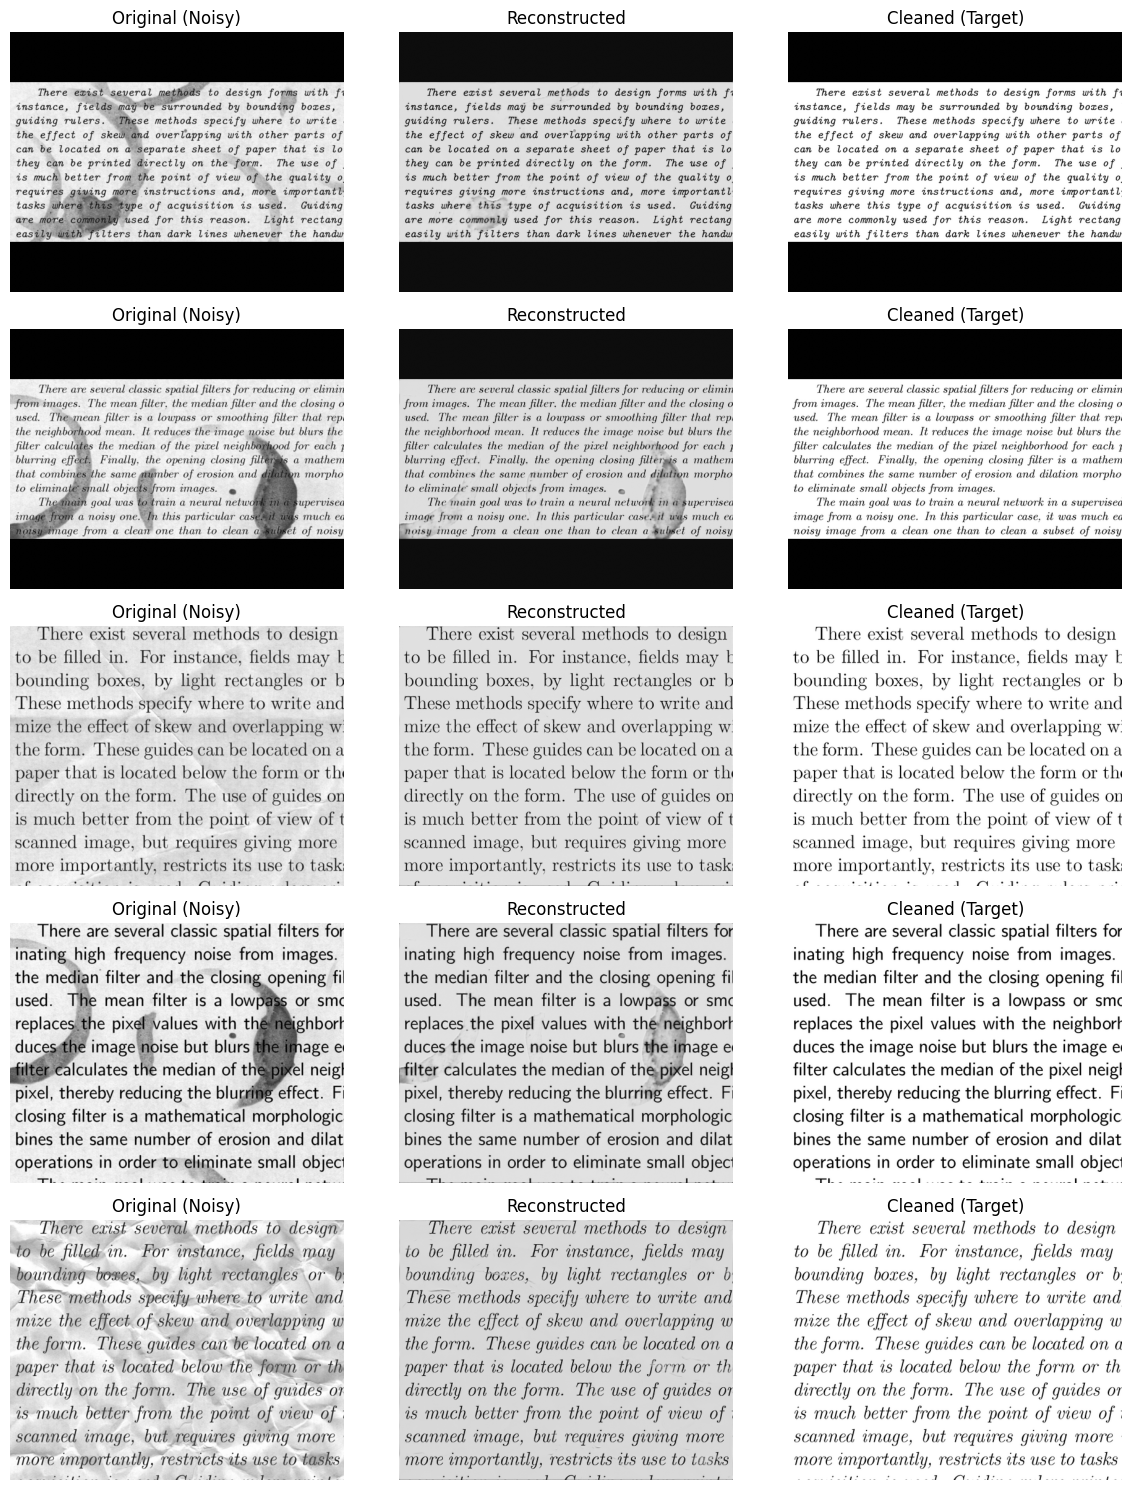

In [ ]:
# -------------------------------
#  훈련 세트에서 복원 결과 확인
# -------------------------------
model.eval()
with torch.no_grad():
    for train_imgs, cleaned_imgs in train_loader:
        train_imgs = train_imgs.to(device)
        cleaned_imgs = cleaned_imgs.to(device)
        outputs = model(train_imgs)

        num_images = 5
        fig, axes = plt.subplots(num_images, 3, figsize=(12, num_images*3))
        for i in range(num_images):
            axes[i,0].imshow(train_imgs[i].cpu().squeeze(), cmap='gray')
            axes[i,0].set_title("Original (Noisy)")
            axes[i,0].axis('off')

            axes[i,1].imshow(outputs[i].cpu().squeeze(), cmap='gray')
            axes[i,1].set_title("Reconstructed")
            axes[i,1].axis('off')

            axes[i,2].imshow(cleaned_imgs[i].cpu().squeeze(), cmap='gray')
            axes[i,2].set_title("Cleaned (Target)")
            axes[i,2].axis('off')

        plt.tight_layout()
        plt.show()
        break


- 데이터를 모델에 넣고 결과를 시각화 하니 굉장히 우수한 성능이 나옴, 기존 예제에서는 중간 압축과정에서 굉장히 흐릿한모습을 보엿는데  노이즈가 거의 완벽에가깝게 제거된 모습이보임, 이제 테스트 이미지를 복원시 좋은결과로 이어질듯한 예감이 듭니다.

<h3>3. 테스트 이미지 복원 및 평가</h3>

- 이제 드디어 테스트이미지를 가지고 학습한 모델로 복원할 단계입니다. 

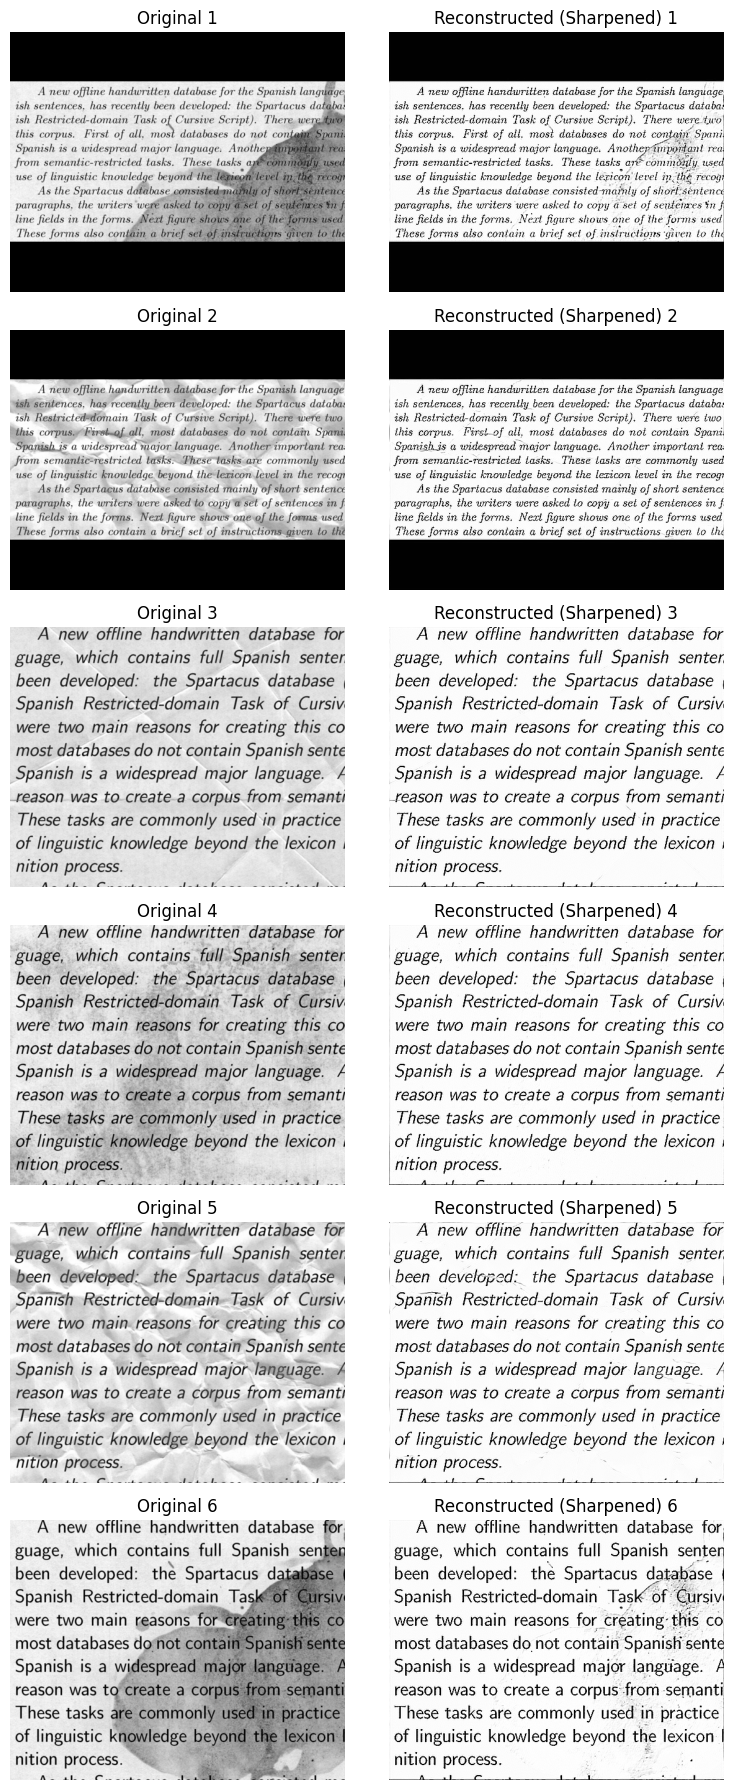

✅ 평균 RMSE: 0.197860
✅ 평균 PSNR: 14.2929 dB
✅ 평균 SSIM: 0.7512


In [45]:
from skimage.metrics import peak_signal_noise_ratio as psnr_metric, structural_similarity as ssim_metric


model.eval()
rmse_list, psnr_list, ssim_list = [], [], []

with torch.no_grad():
    for test_imgs in test_loader:
        test_imgs = test_imgs.to(device)
        reconstructed = model(test_imgs)

        # 샤프닝 적용
        reconstructed_sharp = torch.stack([sharpen_image(img) for img in reconstructed])

        # 6개 시각화
        fig, axes = plt.subplots(6, 2, figsize=(8, 18))
        for i in range(6):
            original = test_imgs[i].cpu().squeeze().numpy()
            output = reconstructed_sharp[i].cpu().squeeze().numpy()

            # 시각화
            axes[i, 0].imshow(original, cmap='gray')
            axes[i, 0].set_title(f"Original {i+1}")
            axes[i, 0].axis('off')

            axes[i, 1].imshow(output, cmap='gray')
            axes[i, 1].set_title(f"Reconstructed (Sharpened) {i+1}")
            axes[i, 1].axis('off')

            # 🔹 RMSE, PSNR, SSIM 계산
            rmse_val = np.sqrt(np.mean((original - output) ** 2))
            psnr_val = psnr_metric(original, output, data_range=1.0)
            ssim_val = ssim_metric(original, output, data_range=1.0)

            rmse_list.append(rmse_val)
            psnr_list.append(psnr_val)
            ssim_list.append(ssim_val)

        plt.tight_layout()
        plt.show()

        # 한 배치만 평가 (원하면 break 제거)
        break

# ================================
# ✅ 성능 요약
# ================================
print(f"✅ 평균 RMSE: {np.mean(rmse_list):.6f}")
print(f"✅ 평균 PSNR: {np.mean(psnr_list):.4f} dB")
print(f"✅ 평균 SSIM: {np.mean(ssim_list):.4f}")

최종 성능 평가

| **지표**   | **값**      | **해석**                                        |
| -------- | ---------- | --------------------------------------------- |
| **RMSE** | 0.197860   | 출력과 원본 간의 평균 오차. **낮을수록 복원 정확도 높음.**          |
| **PSNR** | 14.2929 dB | 복원 이미지의 품질 지표.  |
| **SSIM** | 0.7512     | 구조적 유사도.   |






- RMSE 0.1979 값이 0이면 완벽하게 일치, 1에 가까울수록 오차가 큼 0.19 정도면, 중간 이상 수준의 복원 성능
- PSNR 14.29db는 중간수준으로 실제 이미지와 비교시 노이즈 제거되었지만 아직 세부디테일은 부족함 
- SSIM 0.7512  1에 가까울 수록 좋은데 실제 텍스트보면 큰무리없이 보여서 잘나온듯합니다.

